# Unsupervised Learning: Clustering and Dimensionality Reduction
## Module 9, Lab 6: Discovering Hidden Patterns in Data

Unlike supervised learning where we have target labels, unsupervised learning finds hidden patterns in data without knowing the "correct" answers. This lab explores clustering techniques to group similar data points and dimensionality reduction to visualize complex data.

### Learning Objectives
By the end of this lab, you will be able to:
- Understand the principles of unsupervised learning
- Apply K-Means clustering to segment customers
- Use hierarchical clustering for different grouping strategies
- Evaluate clustering quality using various metrics
- Apply Principal Component Analysis (PCA) for dimensionality reduction
- Visualize high-dimensional data in 2D/3D space
- Interpret business insights from clustering results

### Business Applications
Unsupervised learning is crucial for:
- Customer segmentation for targeted marketing
- Market research and product positioning
- Anomaly detection in fraud prevention
- Data exploration and pattern discovery
- Dimensionality reduction for visualization

## Setup and Data Loading

In [1]:
# Install required packages
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn plotly

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


### Creating a Customer Dataset for Segmentation
We'll create a realistic customer dataset with multiple dimensions for clustering analysis.

In [3]:
# Create a comprehensive customer dataset
np.random.seed(42)
n_customers = 1000

# Create different customer segments with distinct characteristics
# Segment 1: Young Professionals (25% of customers)
n_young_prof = int(0.25 * n_customers)
young_prof = {
    'age': np.random.normal(28, 4, n_young_prof),
    'income': np.random.normal(55000, 15000, n_young_prof),
    'spending_score': np.random.normal(70, 15, n_young_prof),
    'frequency_visits': np.random.normal(8, 2, n_young_prof),
    'avg_transaction': np.random.normal(85, 20, n_young_prof),
    'online_purchases': np.random.normal(12, 3, n_young_prof),
    'loyalty_years': np.random.normal(2, 1, n_young_prof)
}

# Segment 2: Affluent Families (30% of customers)
n_affluent = int(0.30 * n_customers)
affluent = {
    'age': np.random.normal(42, 8, n_affluent),
    'income': np.random.normal(95000, 25000, n_affluent),
    'spending_score': np.random.normal(85, 10, n_affluent),
    'frequency_visits': np.random.normal(6, 2, n_affluent),
    'avg_transaction': np.random.normal(150, 30, n_affluent),
    'online_purchases': np.random.normal(8, 2, n_affluent),
    'loyalty_years': np.random.normal(5, 2, n_affluent)
}

# Segment 3: Budget Conscious (25% of customers)
n_budget = int(0.25 * n_customers)
budget = {
    'age': np.random.normal(35, 12, n_budget),
    'income': np.random.normal(40000, 12000, n_budget),
    'spending_score': np.random.normal(35, 10, n_budget),
    'frequency_visits': np.random.normal(4, 1, n_budget),
    'avg_transaction': np.random.normal(45, 15, n_budget),
    'online_purchases': np.random.normal(3, 1, n_budget),
    'loyalty_years': np.random.normal(3, 2, n_budget)
}

# Segment 4: Senior Customers (20% of customers)
n_senior = n_customers - n_young_prof - n_affluent - n_budget
senior = {
    'age': np.random.normal(65, 8, n_senior),
    'income': np.random.normal(70000, 20000, n_senior),
    'spending_score': np.random.normal(50, 15, n_senior),
    'frequency_visits': np.random.normal(3, 1, n_senior),
    'avg_transaction': np.random.normal(75, 25, n_senior),
    'online_purchases': np.random.normal(2, 1, n_senior),
    'loyalty_years': np.random.normal(8, 3, n_senior)
}

# Combine all segments
customer_data = {}
for key in young_prof.keys():
    customer_data[key] = np.concatenate([
        young_prof[key], affluent[key], budget[key], senior[key]
    ])

# Add true segment labels (for evaluation purposes only)
true_segments = (['Young Professional'] * n_young_prof + 
                ['Affluent Family'] * n_affluent + 
                ['Budget Conscious'] * n_budget + 
                ['Senior Customer'] * n_senior)

customer_data['true_segment'] = true_segments

# Create DataFrame
df = pd.DataFrame(customer_data)

# Apply realistic constraints
df['age'] = np.clip(df['age'], 18, 80)
df['income'] = np.clip(df['income'], 20000, 200000)
df['spending_score'] = np.clip(df['spending_score'], 1, 100)
df['frequency_visits'] = np.clip(df['frequency_visits'], 1, 15)
df['avg_transaction'] = np.clip(df['avg_transaction'], 10, 300)
df['online_purchases'] = np.clip(df['online_purchases'], 0, 20)
df['loyalty_years'] = np.clip(df['loyalty_years'], 0, 15)

# Add some derived features
df['annual_spending'] = df['frequency_visits'] * df['avg_transaction'] * 12
df['online_ratio'] = df['online_purchases'] / (df['frequency_visits'] + 1)
df['spending_to_income'] = df['annual_spending'] / df['income']

print(f"Dataset created with {len(df)} customers")
print(f"Dataset shape: {df.shape}")
print(f"\nTrue segment distribution:")
print(df['true_segment'].value_counts())
df.head()

Dataset created with 1000 customers
Dataset shape: (1000, 11)

True segment distribution:
true_segment
Affluent Family       300
Young Professional    250
Budget Conscious      250
Senior Customer       200
Name: count, dtype: int64


,age,income,spending_score,frequency_visits,avg_transaction,online_purchases,loyalty_years,true_segment,annual_spending,online_ratio,spending_to_income
0,29.986857,36086.740685,83.892663,6.153534,112.987109,12.992641,2.778361,Young Professional,8343.239514,1.816255,0.231200
1,27.446943,68767.929206,98.641250,5.296631,103.492674,14.500587,1.448814,Young Professional,6577.949781,2.302912,0.095654
2,30.590754,86832.342955,49.021486,6.048253,86.192607,6.018793,1.181801,Young Professional,6255.776866,0.853941,0.072044
3,34.092119,70486.978908,78.444539,10.107284,72.061264,13.122170,1.996626,Young Professional,8740.123630,1.181402,0.123996
4,27.063387,32209.450511,60.240361,6.101202,98.964466,15.683007,1.829815,Young Professional,7245.626659,2.208500,0.224953


## Step 1: Exploratory Data Analysis
Let's explore our data before applying clustering algorithms.

Dataset Statistics:
           age     income  spending_score  frequency_visits  avg_transaction  \
count  1000.00    1000.00         1000.00           1000.00          1000.00   
mean     41.18   65847.34           61.44              5.45            92.35   
std      15.04   28782.23           22.90              2.52            46.23   
min      18.00   20000.00            9.31              1.00            10.00   
25%      29.13   42921.14           41.53              3.59            55.82   
50%      38.57   60374.23           63.24              4.92            84.86   
75%      50.92   85476.05           81.18              7.16           121.56   
max      80.00  172747.96          100.00             13.85           236.05   

       online_purchases  loyalty_years  annual_spending  online_ratio  \
count           1000.00        1000.00          1000.00       1000.00   
mean               6.66           4.28          6441.62          1.00   
std                4.52           2.90  

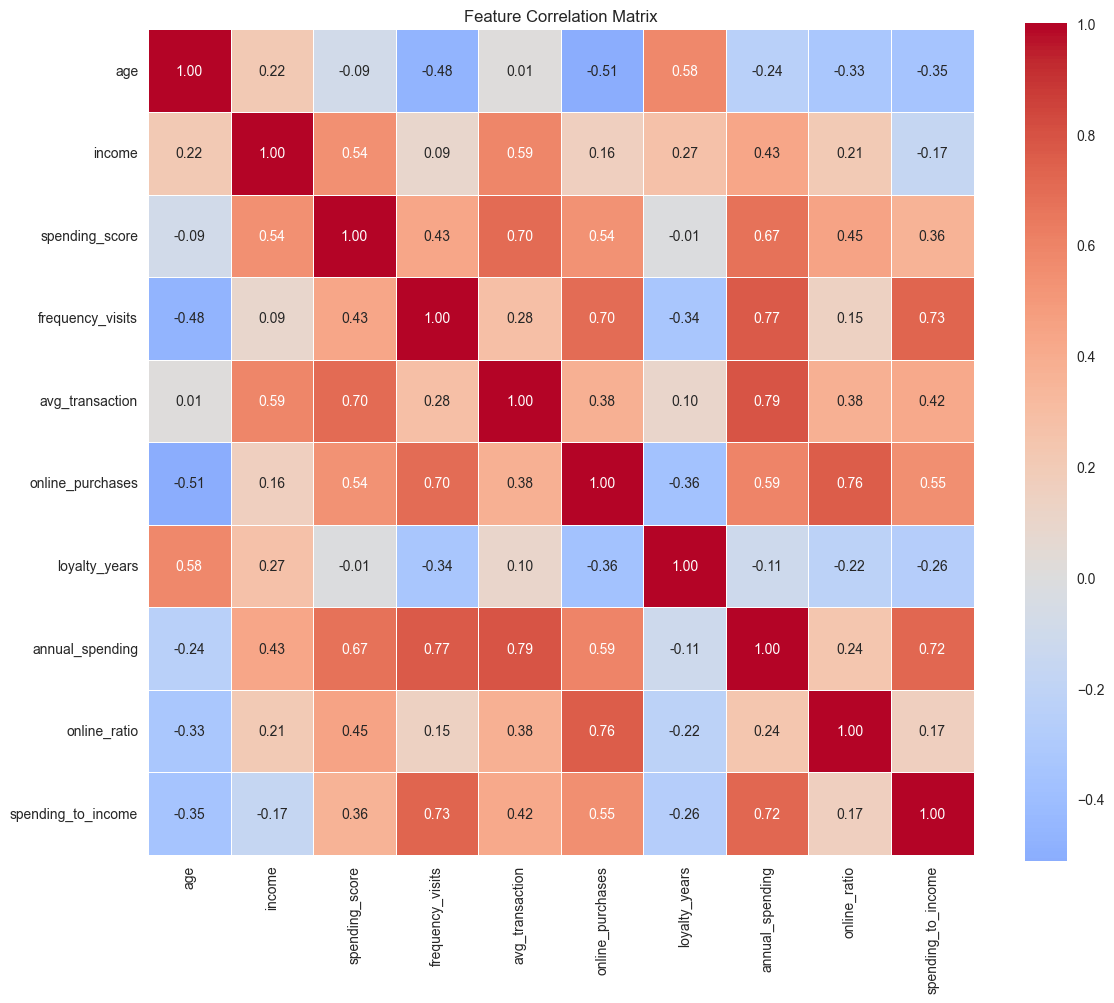

In [4]:
# Basic statistics
numerical_cols = ['age', 'income', 'spending_score', 'frequency_visits', 
                 'avg_transaction', 'online_purchases', 'loyalty_years',
                 'annual_spending', 'online_ratio', 'spending_to_income']

print("Dataset Statistics:")
print(df[numerical_cols].describe().round(2))

# Check for correlations
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

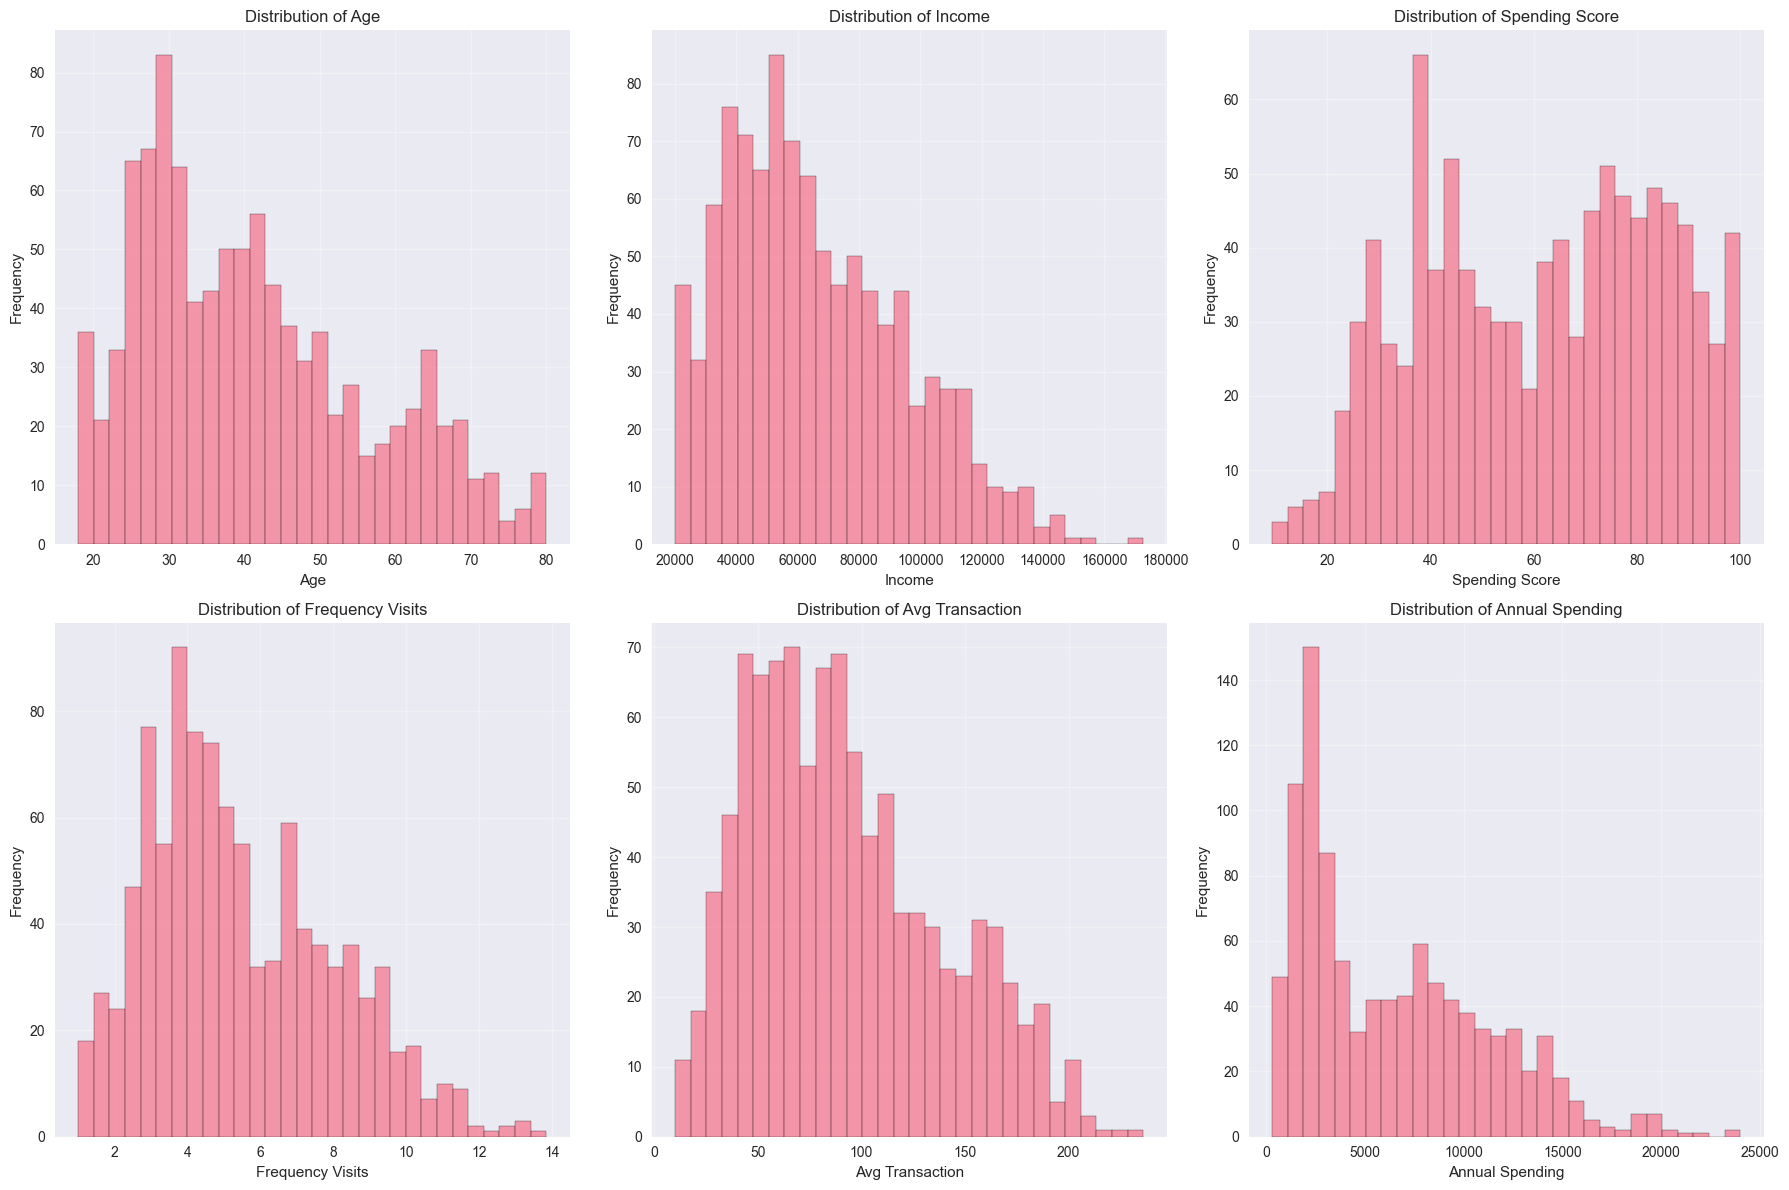

In [5]:
# Visualize distributions and relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

key_features = ['age', 'income', 'spending_score', 'frequency_visits', 'avg_transaction', 'annual_spending']

for i, feature in enumerate(key_features):
    axes[i].hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {feature.replace("_", " ").title()}')
    axes[i].set_xlabel(feature.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

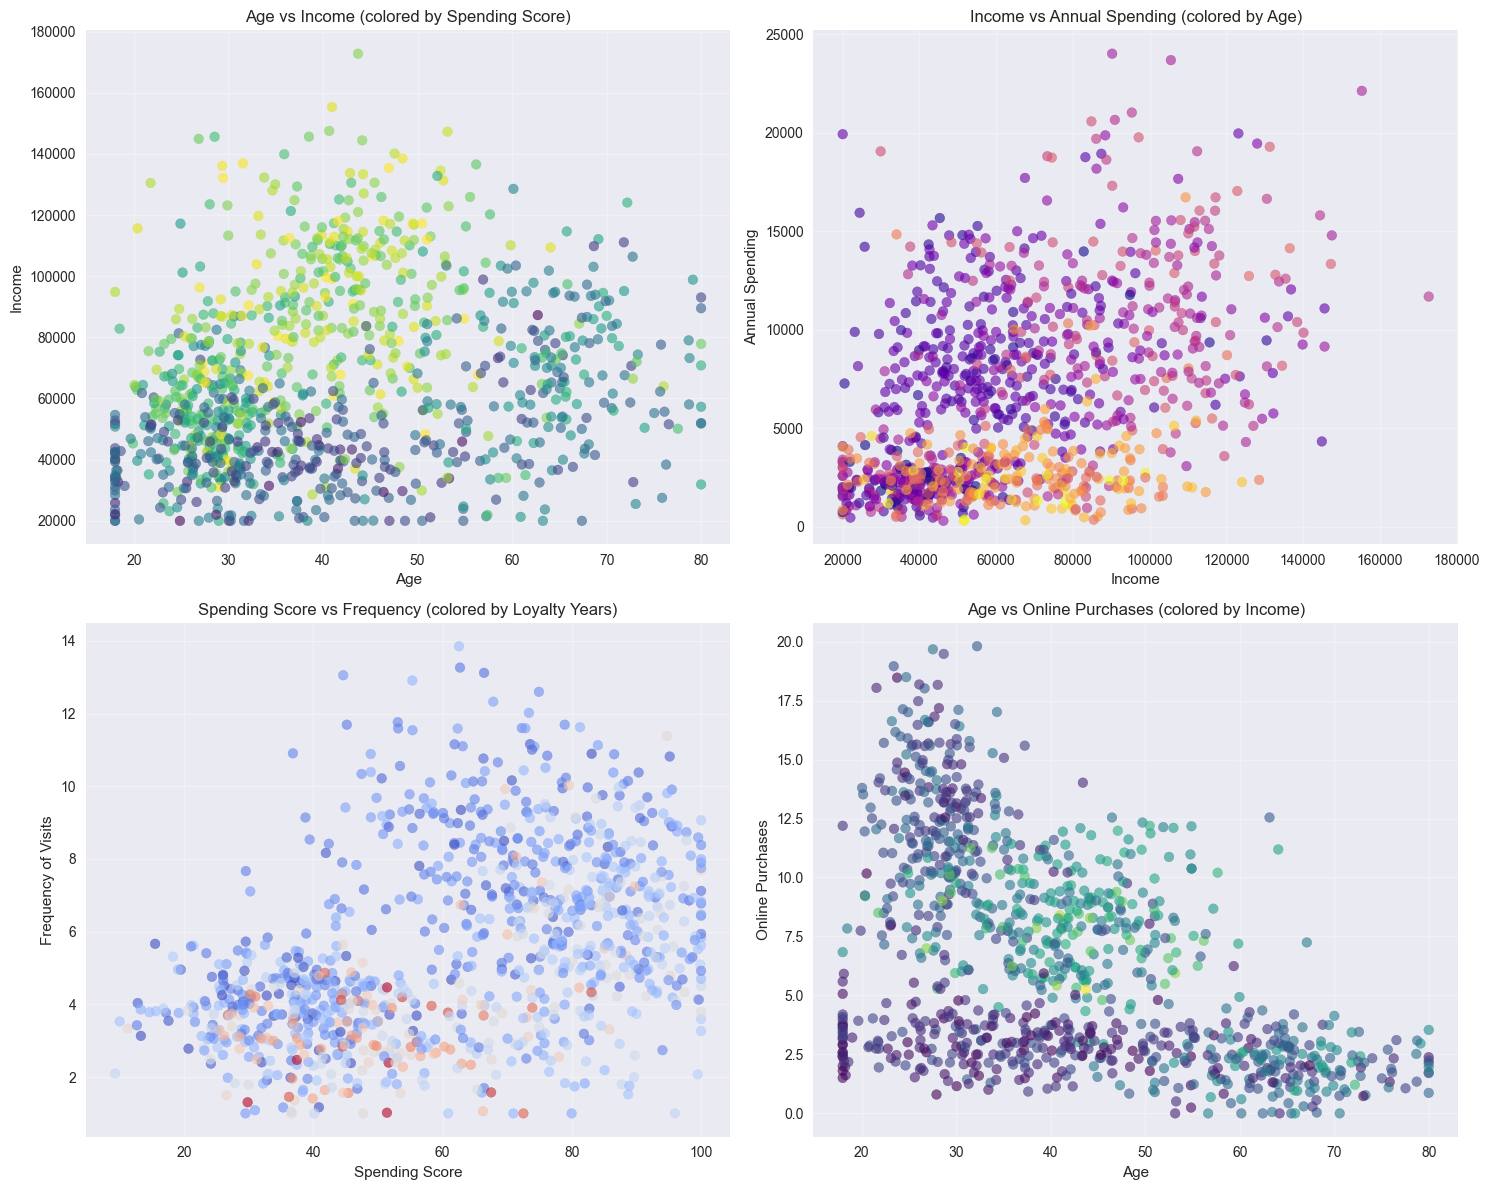

In [6]:
# Create scatter plots to visualize potential clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age vs Income
axes[0, 0].scatter(df['age'], df['income'], alpha=0.6, c=df['spending_score'], cmap='viridis')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Income')
axes[0, 0].set_title('Age vs Income (colored by Spending Score)')
axes[0, 0].grid(True, alpha=0.3)

# Income vs Annual Spending
axes[0, 1].scatter(df['income'], df['annual_spending'], alpha=0.6, c=df['age'], cmap='plasma')
axes[0, 1].set_xlabel('Income')
axes[0, 1].set_ylabel('Annual Spending')
axes[0, 1].set_title('Income vs Annual Spending (colored by Age)')
axes[0, 1].grid(True, alpha=0.3)

# Spending Score vs Frequency
axes[1, 0].scatter(df['spending_score'], df['frequency_visits'], alpha=0.6, c=df['loyalty_years'], cmap='coolwarm')
axes[1, 0].set_xlabel('Spending Score')
axes[1, 0].set_ylabel('Frequency of Visits')
axes[1, 0].set_title('Spending Score vs Frequency (colored by Loyalty Years)')
axes[1, 0].grid(True, alpha=0.3)

# Online Purchases vs Age
axes[1, 1].scatter(df['age'], df['online_purchases'], alpha=0.6, c=df['income'], cmap='viridis')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Online Purchases')
axes[1, 1].set_title('Age vs Online Purchases (colored by Income)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 2: Data Preprocessing for Clustering
Clustering algorithms are sensitive to feature scales, so we need to normalize our data.

In [7]:
# Select features for clustering (exclude true_segment as it's our ground truth)
clustering_features = ['age', 'income', 'spending_score', 'frequency_visits', 
                      'avg_transaction', 'online_purchases', 'loyalty_years']

X = df[clustering_features].copy()

print(f"Features for clustering: {clustering_features}")
print(f"Data shape: {X.shape}")
print(f"\nFeature ranges before scaling:")
for col in clustering_features:
    print(f"  {col}: {X[col].min():.2f} to {X[col].max():.2f}")

Features for clustering: ['age', 'income', 'spending_score', 'frequency_visits', 'avg_transaction', 'online_purchases', 'loyalty_years']
Data shape: (1000, 7)

Feature ranges before scaling:
  age: 18.00 to 80.00
  income: 20000.00 to 172747.96
  spending_score: 9.31 to 100.00
  frequency_visits: 1.00 to 13.85
  avg_transaction: 10.00 to 236.05
  online_purchases: 0.00 to 19.81
  loyalty_years: 0.00 to 15.00


In [8]:
# Apply different scaling methods
# StandardScaler (mean=0, std=1)
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X)
X_standard_df = pd.DataFrame(X_standard, columns=clustering_features)

# MinMaxScaler (range 0-1)
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)
X_minmax_df = pd.DataFrame(X_minmax, columns=clustering_features)

print("Scaling applied successfully!")
print(f"\nStandard scaled data statistics:")
print(X_standard_df.describe().round(3))

print(f"\nMin-Max scaled data statistics:")
print(X_minmax_df.describe().round(3))

Scaling applied successfully!

Standard scaled data statistics:
            age    income  spending_score  frequency_visits  avg_transaction  \
count  1000.000  1000.000        1000.000          1000.000         1000.000   
mean      0.000    -0.000          -0.000            -0.000           -0.000   
std       1.001     1.001           1.001             1.001            1.001   
min      -1.542    -1.594          -2.278            -1.767           -1.782   
25%      -0.801    -0.797          -0.870            -0.738           -0.791   
50%      -0.174    -0.190           0.079            -0.211           -0.162   
75%       0.648     0.682           0.862             0.677            0.632   
max       2.582     3.716           1.685             3.332            3.110   

       online_purchases  loyalty_years  
count          1000.000       1000.000  
mean              0.000          0.000  
std               1.001          1.001  
min              -1.475         -1.474  
25%       

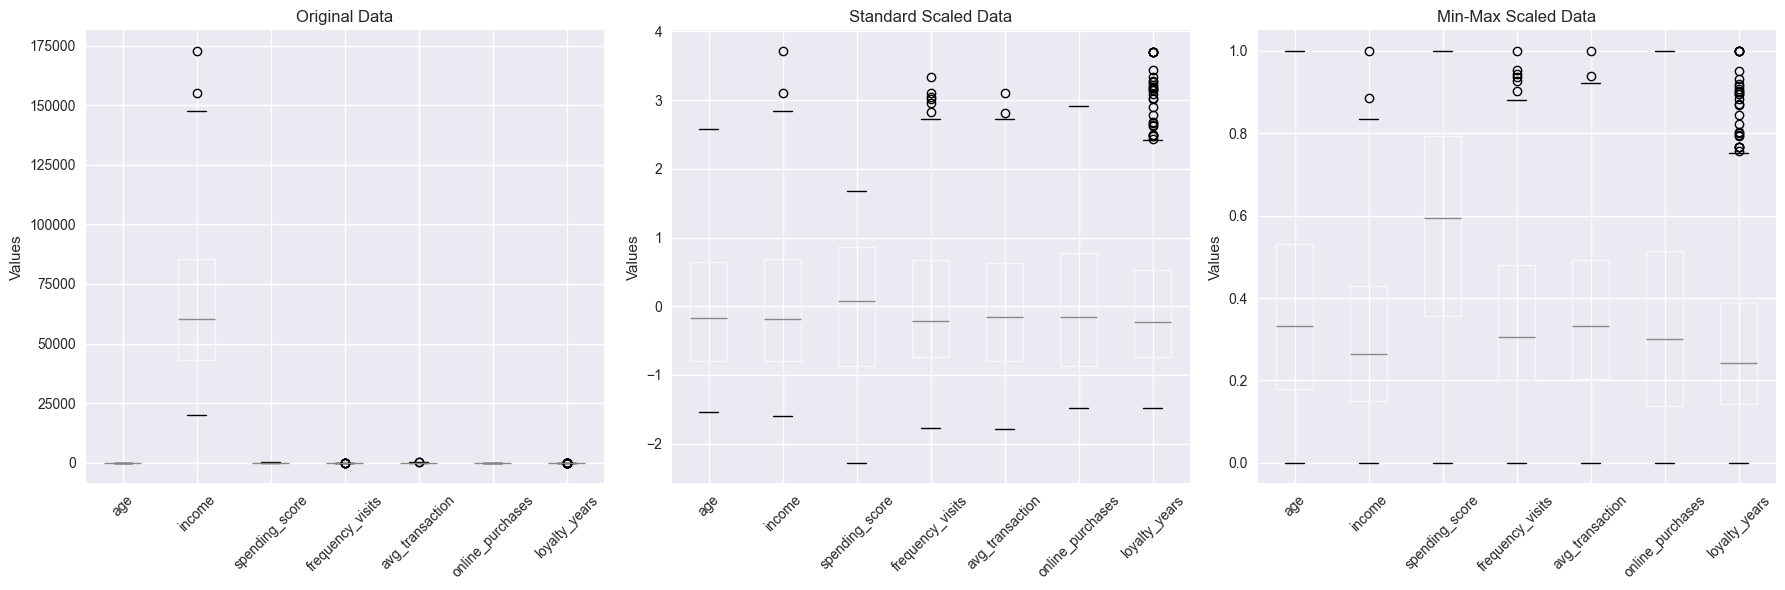


Using standard scaled data for clustering analysis.


In [9]:
# Visualize the effect of scaling
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original data
X.boxplot(ax=axes[0])
axes[0].set_title('Original Data')
axes[0].set_ylabel('Values')
axes[0].tick_params(axis='x', rotation=45)

# Standard scaled
X_standard_df.boxplot(ax=axes[1])
axes[1].set_title('Standard Scaled Data')
axes[1].set_ylabel('Values')
axes[1].tick_params(axis='x', rotation=45)

# Min-max scaled
X_minmax_df.boxplot(ax=axes[2])
axes[2].set_title('Min-Max Scaled Data')
axes[2].set_ylabel('Values')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# We'll use standard scaled data for clustering
X_scaled = X_standard
print("\nUsing standard scaled data for clustering analysis.")

## Step 3: K-Means Clustering
Let's start with K-Means, one of the most popular clustering algorithms.

### 3.1 Finding the Optimal Number of Clusters

Finding optimal number of clusters...
k=2: Inertia=4352.89, Silhouette=0.356
k=3: Inertia=3297.88, Silhouette=0.344
k=4: Inertia=2338.31, Silhouette=0.385
k=5: Inertia=2168.31, Silhouette=0.351
k=6: Inertia=2028.60, Silhouette=0.295
k=7: Inertia=1932.93, Silhouette=0.237
k=8: Inertia=1852.02, Silhouette=0.177
k=9: Inertia=1773.50, Silhouette=0.170
k=10: Inertia=1722.49, Silhouette=0.165


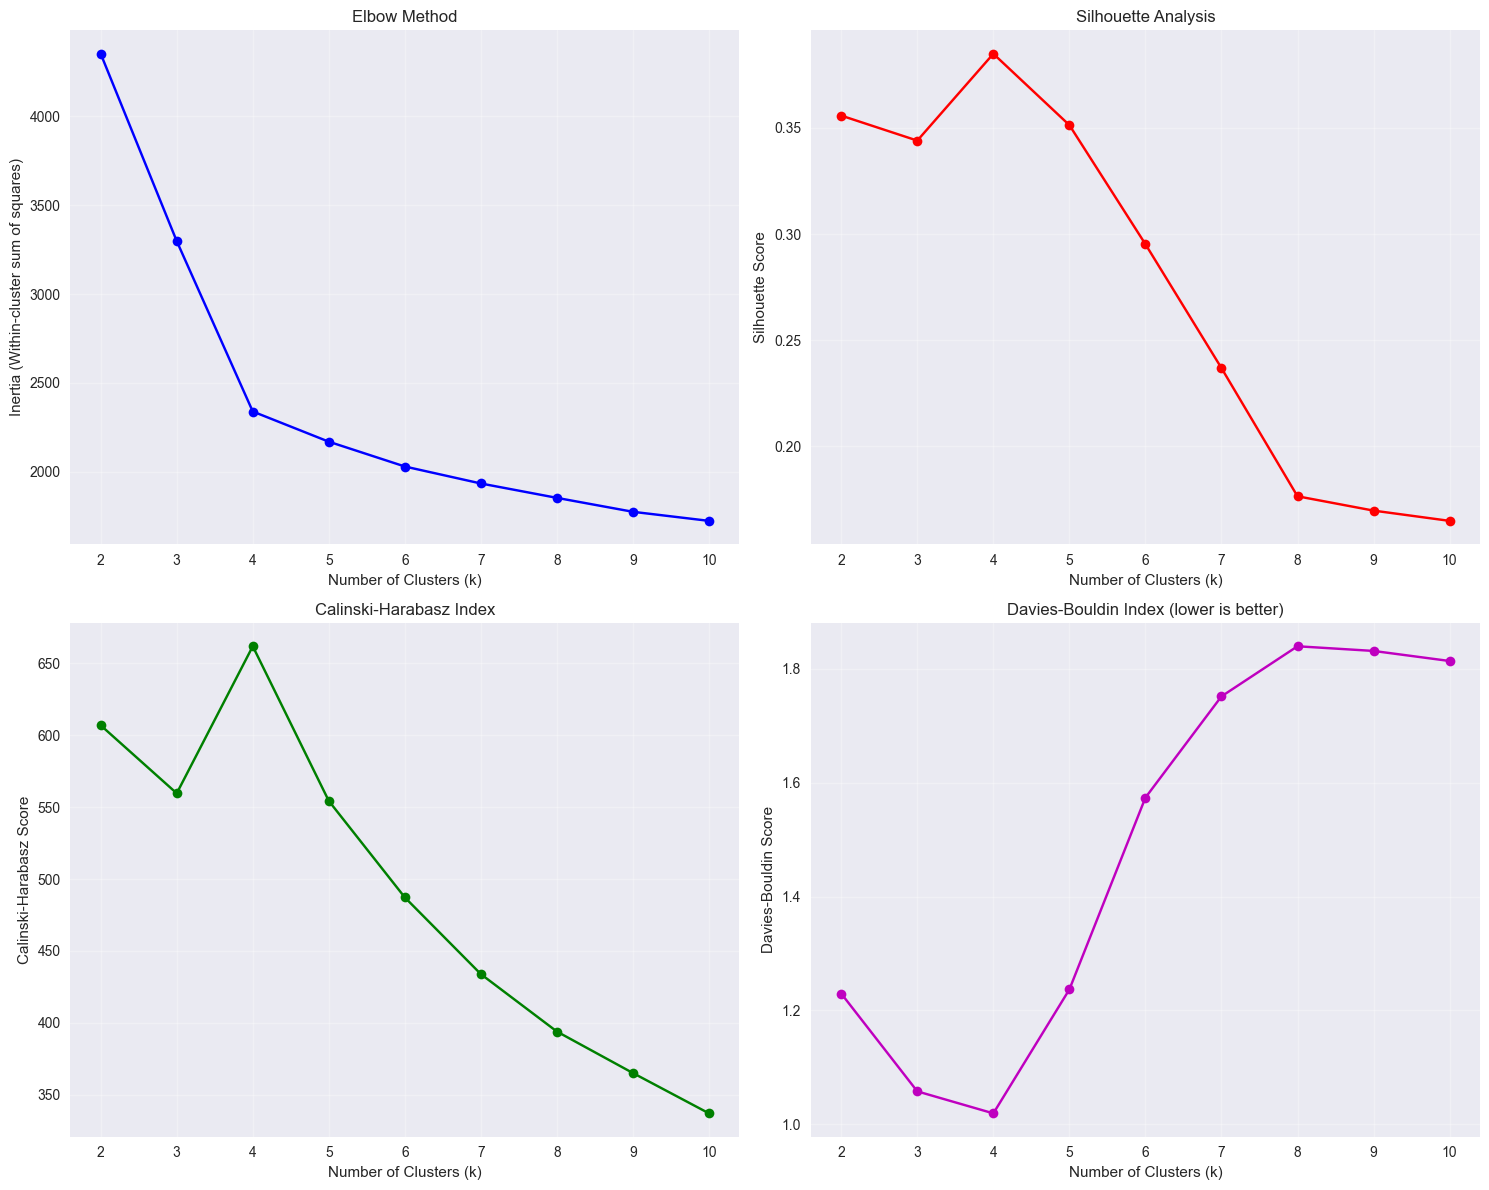


Optimal number of clusters based on Silhouette Score: 4
Best Silhouette Score: 0.385


In [10]:
# Elbow Method - find optimal k
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Finding optimal number of clusters...")
for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, cluster_labels))
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Elbow curve
axes[0, 0].plot(k_range, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'ro-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Analysis')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz score
axes[1, 0].plot(k_range, calinski_scores, 'go-')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Index')
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin score (lower is better)
axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Index (lower is better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")

### 3.2 Apply K-Means with Optimal K

In [11]:
# Apply K-Means with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['kmeans_cluster'] = kmeans_labels

print(f"K-Means clustering completed with {optimal_k} clusters")
print(f"\nCluster distribution:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} customers ({count/len(df)*100:.1f}%)")

# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, kmeans_labels)
final_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
final_davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {final_silhouette:.3f} (higher is better, range: -1 to 1)")
print(f"  Calinski-Harabasz Score: {final_calinski:.2f} (higher is better)")
print(f"  Davies-Bouldin Score: {final_davies_bouldin:.3f} (lower is better)")

K-Means clustering completed with 4 clusters

Cluster distribution:
  Cluster 0: 296 customers (29.6%)
  Cluster 1: 249 customers (24.9%)
  Cluster 2: 251 customers (25.1%)
  Cluster 3: 204 customers (20.4%)

Clustering Quality Metrics:
  Silhouette Score: 0.385 (higher is better, range: -1 to 1)
  Calinski-Harabasz Score: 661.88 (higher is better)
  Davies-Bouldin Score: 1.019 (lower is better)


Cluster Characteristics (Mean Values):
                  age    income  spending_score  frequency_visits  \
kmeans_cluster                                                      
0               41.74  95995.36           84.87              5.94   
1               34.58  39288.11           34.95              3.97   
2               28.29  55321.11           69.33              8.33   
3               64.27  67472.43           50.09              3.02   

                avg_transaction  online_purchases  loyalty_years  
kmeans_cluster                                                    
0                        148.75              8.08           4.93  
1                         46.17              3.03           2.86  
2                         87.70             12.35           2.11  
3                         72.60              2.01           7.72  


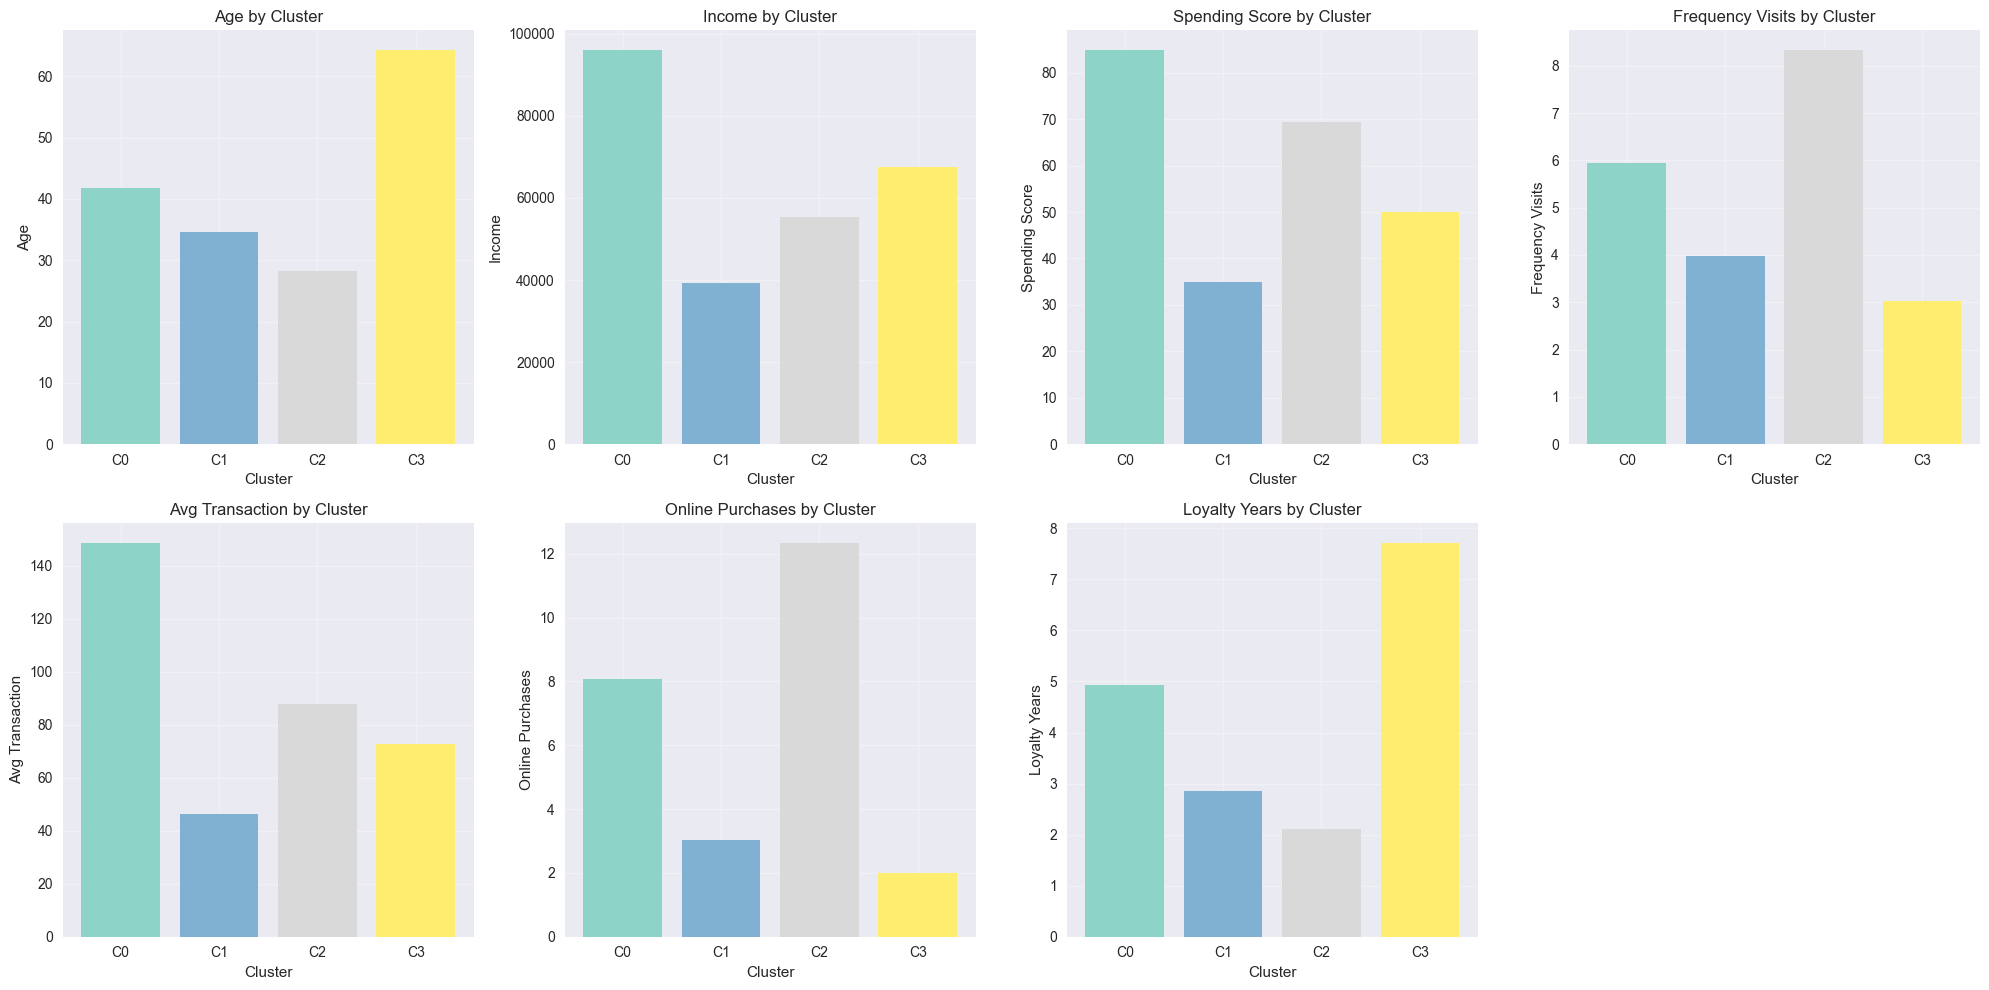

In [12]:
# Analyze cluster characteristics
cluster_analysis = df.groupby('kmeans_cluster')[clustering_features].mean().round(2)
print("Cluster Characteristics (Mean Values):")
print(cluster_analysis)

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(clustering_features):
    cluster_means = cluster_analysis[feature]
    axes[i].bar(range(len(cluster_means)), cluster_means.values, 
                color=plt.cm.Set3(np.linspace(0, 1, len(cluster_means))))
    axes[i].set_title(f'{feature.replace("_", " ").title()} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature.replace("_", " ").title())
    axes[i].set_xticks(range(len(cluster_means)))
    axes[i].set_xticklabels([f'C{i}' for i in range(len(cluster_means))])
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

## Step 4: Hierarchical Clustering
Let's compare K-Means with hierarchical clustering methods.

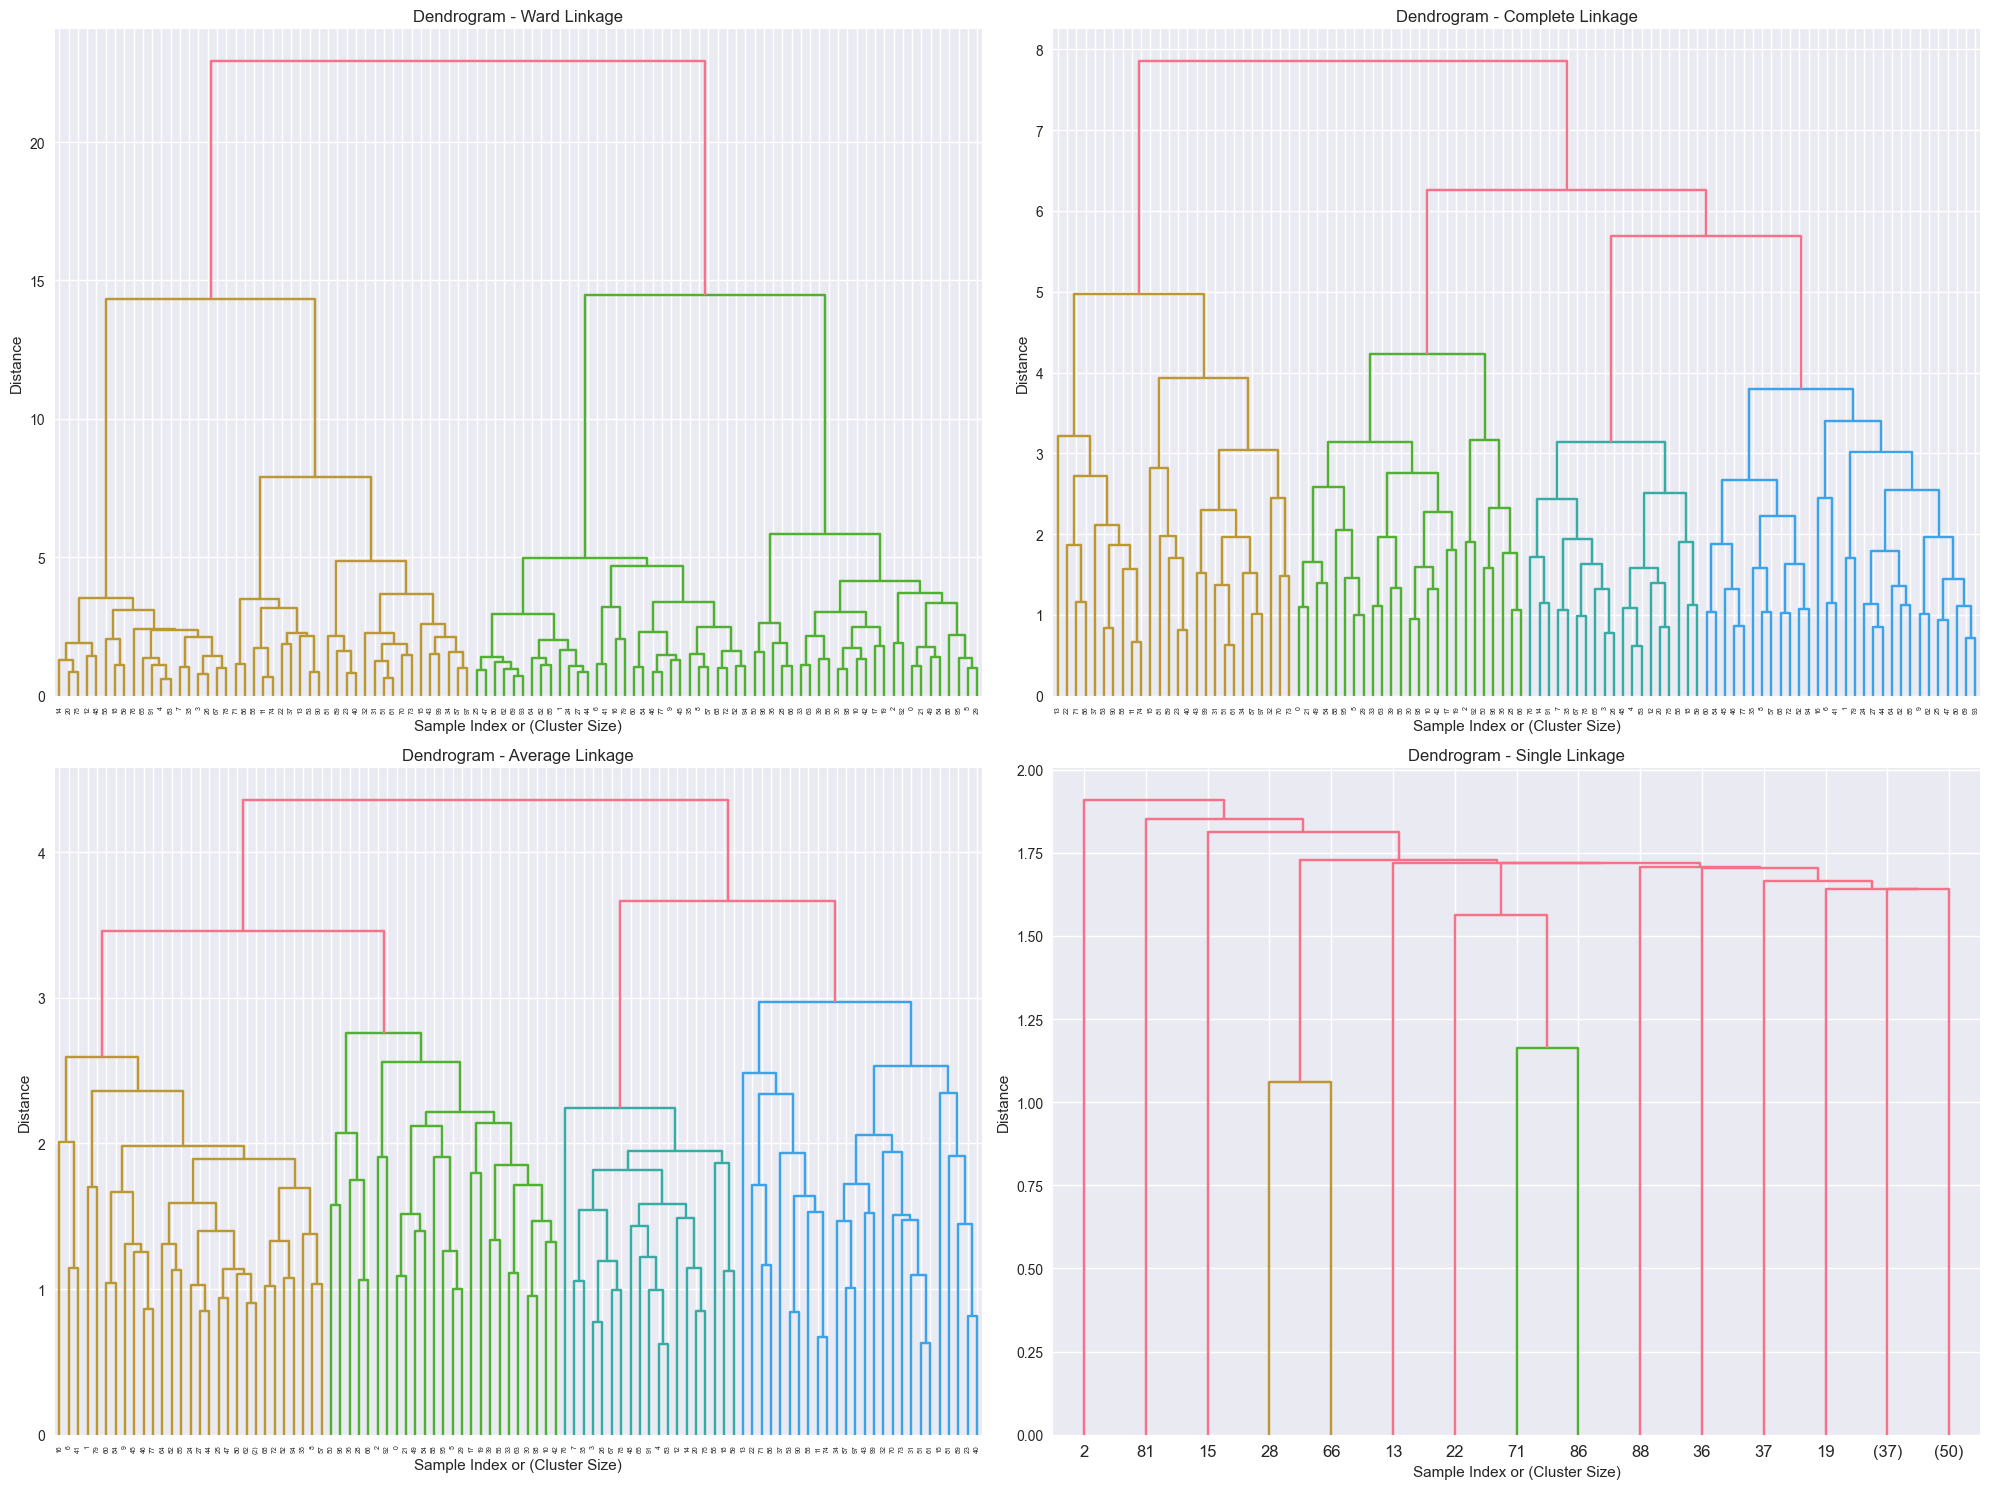

In [13]:
# Create dendrogram to visualize hierarchical clustering
# Use a subset of data for visualization (dendrograms can be messy with too many points)
sample_size = 100
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Calculate linkage matrix
linkage_methods = ['ward', 'complete', 'average', 'single']
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calculate linkage
    Z = linkage(X_sample, method=method)
    
    # Create dendrogram
    dendrogram(Z, ax=axes[i], truncate_mode='level', p=10)
    axes[i].set_title(f'Dendrogram - {method.title()} Linkage')
    axes[i].set_xlabel('Sample Index or (Cluster Size)')
    axes[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

In [14]:
# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

# Add to dataframe
df['hierarchical_cluster'] = agg_labels

print(f"Hierarchical clustering completed with {optimal_k} clusters")
print(f"\nCluster distribution:")
agg_cluster_counts = pd.Series(agg_labels).value_counts().sort_index()
for cluster, count in agg_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} customers ({count/len(df)*100:.1f}%)")

# Calculate metrics for hierarchical clustering
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_calinski = calinski_harabasz_score(X_scaled, agg_labels)
agg_davies_bouldin = davies_bouldin_score(X_scaled, agg_labels)

print(f"\nHierarchical Clustering Quality Metrics:")
print(f"  Silhouette Score: {agg_silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {agg_calinski:.2f}")
print(f"  Davies-Bouldin Score: {agg_davies_bouldin:.3f}")

Hierarchical clustering completed with 4 clusters

Cluster distribution:
  Cluster 0: 203 customers (20.3%)
  Cluster 1: 297 customers (29.7%)
  Cluster 2: 253 customers (25.3%)
  Cluster 3: 247 customers (24.7%)

Hierarchical Clustering Quality Metrics:
  Silhouette Score: 0.381
  Calinski-Harabasz Score: 655.11
  Davies-Bouldin Score: 1.026


## Step 5: Dimensionality Reduction and Visualization
Let's use PCA and t-SNE to visualize our high-dimensional clusters in 2D space.

### 5.1 Principal Component Analysis (PCA)

PCA Analysis:
Number of original features: 7
  PC1: 0.422 (42.2%) - Cumulative: 0.422 (42.2%)
  PC2: 0.306 (30.6%) - Cumulative: 0.728 (72.8%)
  PC3: 0.081 (8.1%) - Cumulative: 0.809 (80.9%)
  PC4: 0.057 (5.7%) - Cumulative: 0.866 (86.6%)
  PC5: 0.056 (5.6%) - Cumulative: 0.922 (92.2%)
  PC6: 0.043 (4.3%) - Cumulative: 0.964 (96.4%)
  PC7: 0.036 (3.6%) - Cumulative: 1.000 (100.0%)


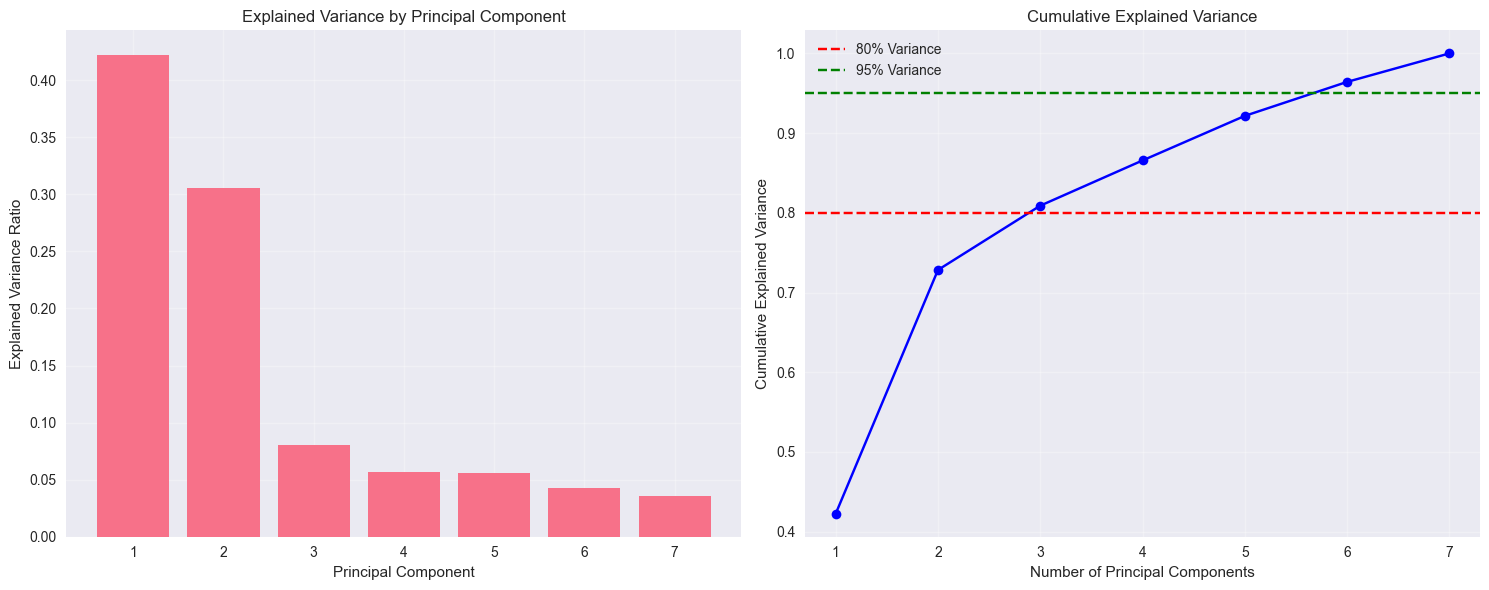


Number of components needed for 95% variance: 6


In [15]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("PCA Analysis:")
print(f"Number of original features: {X_scaled.shape[1]}")
for i, (var, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"  PC{i+1}: {var:.3f} ({var*100:.1f}%) - Cumulative: {cum_var:.3f} ({cum_var*100:.1f}%)")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Individual variance
axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Principal Component')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {n_components_95}")

PCA Component Loadings (First 3 Components):
                    PC1    PC2    PC3
age              -0.293  0.471  0.145
income            0.245  0.502 -0.274
spending_score    0.458  0.286 -0.076
frequency_visits  0.452 -0.191  0.550
avg_transaction   0.388  0.382 -0.250
online_purchases  0.497 -0.154  0.269
loyalty_years    -0.207  0.489  0.679


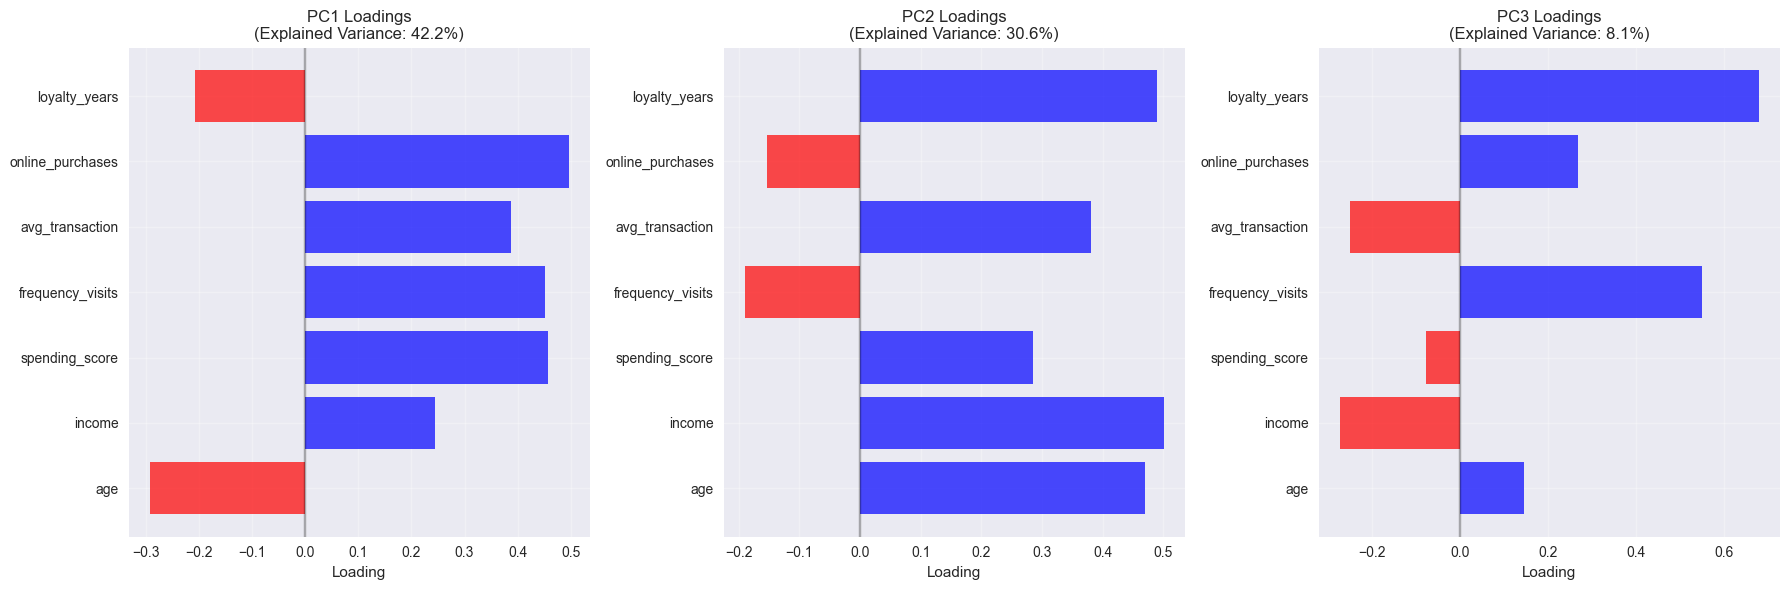

In [16]:
# Analyze PCA components
feature_names = clustering_features
components_df = pd.DataFrame(
    pca.components_[:3].T,  # First 3 components
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_names
)

print("PCA Component Loadings (First 3 Components):")
print(components_df.round(3))

# Visualize component loadings
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    loadings = components_df[pc]
    colors = ['red' if x < 0 else 'blue' for x in loadings]
    axes[i].barh(range(len(loadings)), loadings, color=colors, alpha=0.7)
    axes[i].set_yticks(range(len(loadings)))
    axes[i].set_yticklabels(loadings.index)
    axes[i].set_xlabel('Loading')
    axes[i].set_title(f'{pc} Loadings\n(Explained Variance: {explained_variance_ratio[i]:.1%})')
    axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Cluster Visualization in 2D

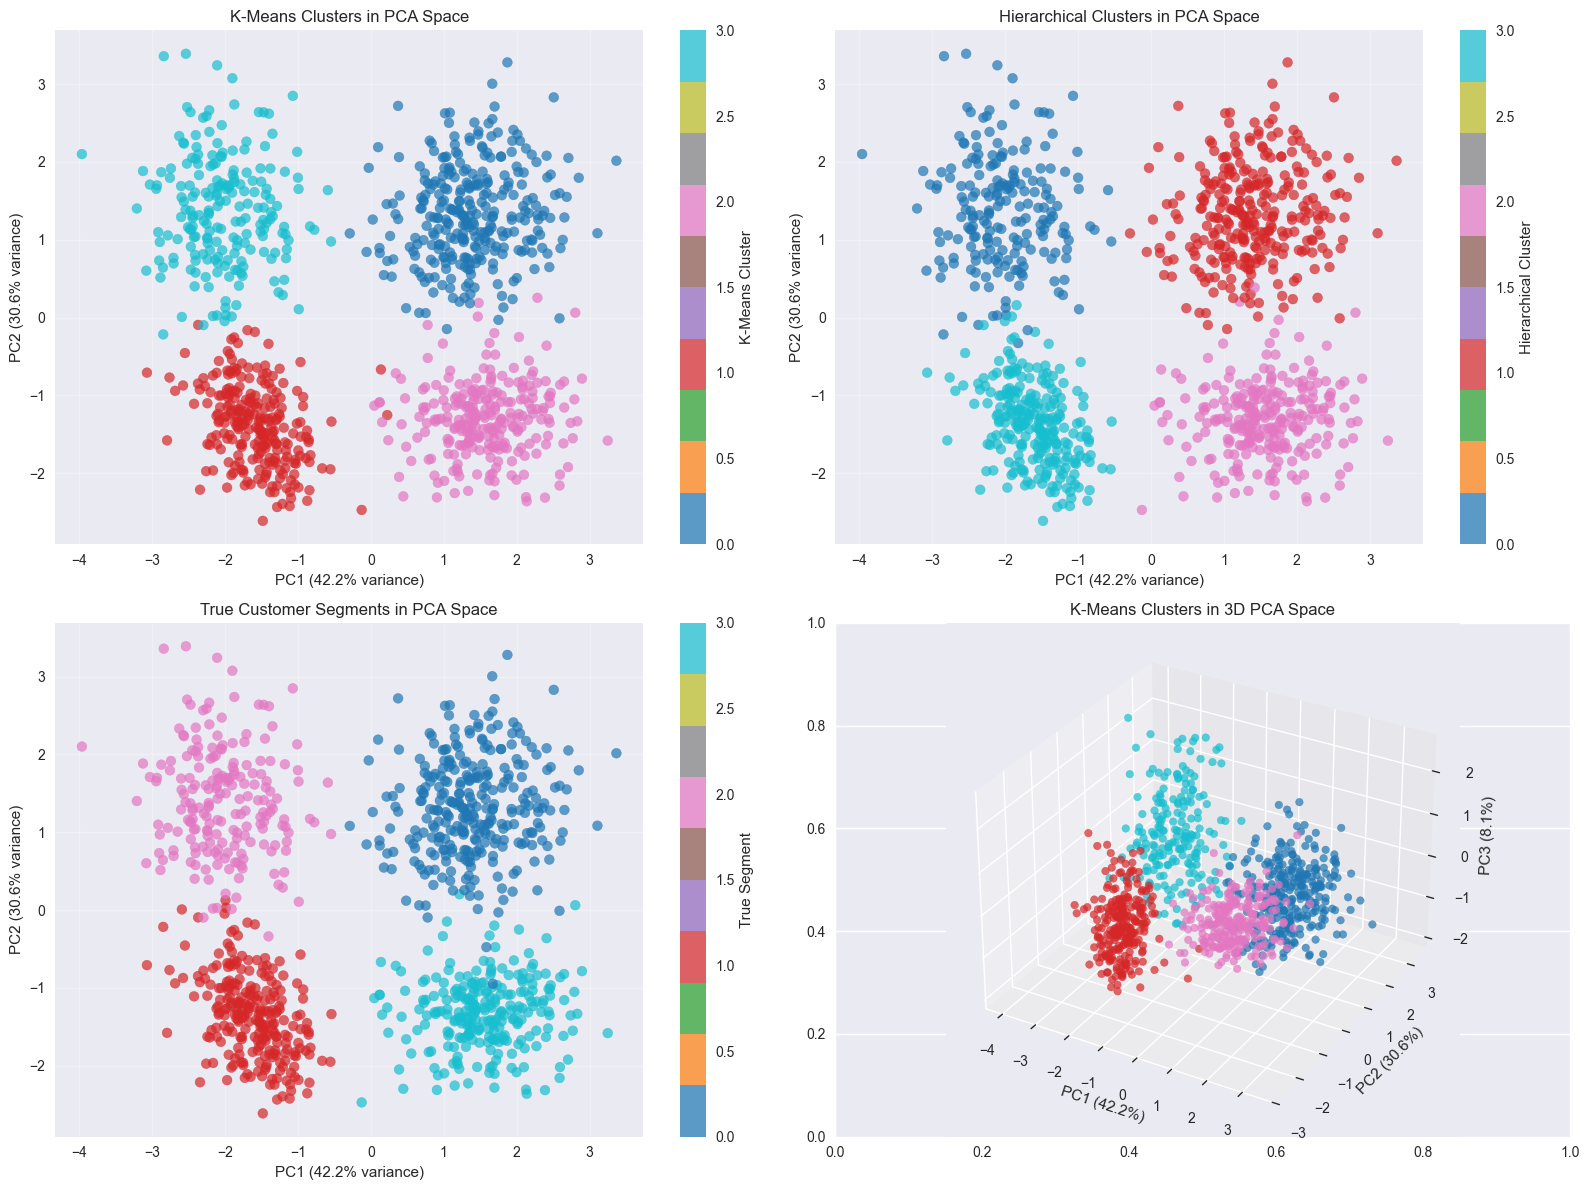

In [17]:
# Create 2D visualizations of clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-Means clusters in PCA space
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=df['kmeans_cluster'], 
                             cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[0, 0].set_title('K-Means Clusters in PCA Space')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='K-Means Cluster')

# Hierarchical clusters in PCA space
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=df['hierarchical_cluster'], 
                             cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[0, 1].set_title('Hierarchical Clusters in PCA Space')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Hierarchical Cluster')

# True segments in PCA space (for comparison)
true_segment_encoded = pd.Categorical(df['true_segment']).codes
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=true_segment_encoded, 
                             cmap='tab10', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[1, 0].set_title('True Customer Segments in PCA Space')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1, 0], label='True Segment')

# 3D visualization using PC1, PC2, PC3
ax_3d = fig.add_subplot(2, 2, 4, projection='3d')
scatter_3d = ax_3d.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                          c=df['kmeans_cluster'], cmap='tab10', alpha=0.7, s=30)
ax_3d.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%})')
ax_3d.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%})')
ax_3d.set_zlabel(f'PC3 ({explained_variance_ratio[2]:.1%})')
ax_3d.set_title('K-Means Clusters in 3D PCA Space')

plt.tight_layout()
plt.show()

### 5.3 t-SNE Visualization

Applying t-SNE (this may take a moment...)


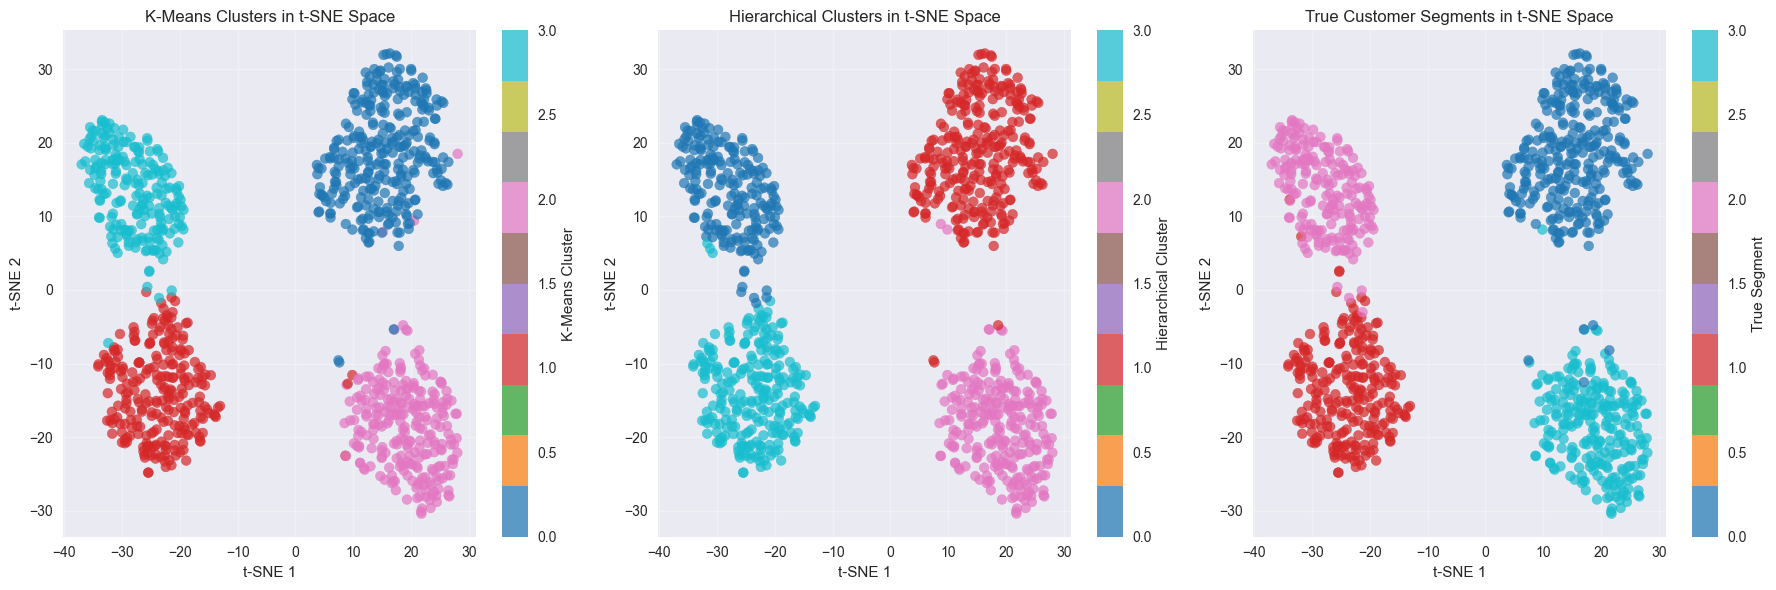

t-SNE visualization completed!


In [19]:
# Apply t-SNE for non-linear dimensionality reduction
print("Applying t-SNE (this may take a moment...)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize clusters in t-SNE space
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means clusters
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['kmeans_cluster'], 
                          cmap='tab10', alpha=0.7, s=50)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title('K-Means Clusters in t-SNE Space')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='K-Means Cluster')

# Hierarchical clusters
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['hierarchical_cluster'], 
                          cmap='tab10', alpha=0.7, s=50)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('Hierarchical Clusters in t-SNE Space')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Hierarchical Cluster')

# True segments
scatter3 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_segment_encoded, 
                          cmap='tab10', alpha=0.7, s=50)
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
axes[2].set_title('True Customer Segments in t-SNE Space')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='True Segment')

plt.tight_layout()
plt.show()

print("t-SNE visualization completed!")

## Step 6: Business Insights and Customer Segmentation Analysis
Let's interpret our clustering results from a business perspective.

In [20]:
# Detailed cluster analysis for business insights
def analyze_clusters(df, cluster_column, cluster_name):
    print(f"\n=== {cluster_name} ANALYSIS ===")
    
    # Cluster sizes
    cluster_sizes = df[cluster_column].value_counts().sort_index()
    print(f"\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} customers ({size/len(df)*100:.1f}%)")
    
    # Detailed statistics by cluster
    cluster_stats = df.groupby(cluster_column)[clustering_features + ['annual_spending', 'spending_to_income']].agg({
        'age': ['mean', 'std'],
        'income': ['mean', 'std'],
        'spending_score': ['mean', 'std'],
        'frequency_visits': ['mean', 'std'],
        'avg_transaction': ['mean', 'std'],
        'online_purchases': ['mean', 'std'],
        'loyalty_years': ['mean', 'std'],
        'annual_spending': ['mean', 'std'],
        'spending_to_income': ['mean', 'std']
    }).round(2)
    
    print(f"\nDetailed Cluster Statistics:")
    print(cluster_stats)
    
    return cluster_stats

# Analyze K-Means clusters
kmeans_stats = analyze_clusters(df, 'kmeans_cluster', 'K-MEANS CLUSTERING')


=== K-MEANS CLUSTERING ANALYSIS ===

Cluster Sizes:
  Cluster 0: 296 customers (29.6%)
  Cluster 1: 249 customers (24.9%)
  Cluster 2: 251 customers (25.1%)
  Cluster 3: 204 customers (20.4%)

Detailed Cluster Statistics:
                  age           income           spending_score         \
                 mean    std      mean       std           mean    std   
kmeans_cluster                                                           
0               41.74   8.08  95995.36  23642.76          84.87   9.26   
1               34.58  10.69  39288.11  11675.49          34.95   9.63   
2               28.29   4.42  55321.11  14763.23          69.33  14.44   
3               64.27   7.75  67472.43  22345.94          50.09  14.78   

               frequency_visits       avg_transaction        online_purchases  \
                           mean   std            mean    std             mean   
kmeans_cluster                                                                  
0              

In [21]:
# Create business personas for each cluster
def create_business_personas(df, cluster_column):
    personas = {}
    
    for cluster in sorted(df[cluster_column].unique()):
        cluster_data = df[df[cluster_column] == cluster]
        
        persona = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(df) * 100,
            'avg_age': cluster_data['age'].mean(),
            'avg_income': cluster_data['income'].mean(),
            'avg_spending_score': cluster_data['spending_score'].mean(),
            'avg_frequency': cluster_data['frequency_visits'].mean(),
            'avg_transaction': cluster_data['avg_transaction'].mean(),
            'avg_online': cluster_data['online_purchases'].mean(),
            'avg_loyalty': cluster_data['loyalty_years'].mean(),
            'total_annual_spending': cluster_data['annual_spending'].sum(),
            'avg_annual_spending': cluster_data['annual_spending'].mean()
        }
        
        personas[cluster] = persona
    
    return personas

# Create personas
kmeans_personas = create_business_personas(df, 'kmeans_cluster')

print("\n=== CUSTOMER PERSONAS (K-MEANS) ===")
for cluster, persona in kmeans_personas.items():
    print(f"\n🎯 CLUSTER {cluster} ({persona['percentage']:.1f}% of customers):")
    print(f"   👥 Size: {persona['size']} customers")
    print(f"   👤 Average Age: {persona['avg_age']:.1f} years")
    print(f"   💰 Average Income: ${persona['avg_income']:,.0f}")
    print(f"   📊 Spending Score: {persona['avg_spending_score']:.1f}/100")
    print(f"   🛍️ Visit Frequency: {persona['avg_frequency']:.1f} times/month")
    print(f"   💳 Average Transaction: ${persona['avg_transaction']:.0f}")
    print(f"   🌐 Online Purchases: {persona['avg_online']:.1f}/month")
    print(f"   ⭐ Loyalty: {persona['avg_loyalty']:.1f} years")
    print(f"   💵 Annual Spending: ${persona['avg_annual_spending']:,.0f}")
    print(f"   📈 Total Segment Value: ${persona['total_annual_spending']:,.0f}")


=== CUSTOMER PERSONAS (K-MEANS) ===

🎯 CLUSTER 0 (29.6% of customers):
   👥 Size: 296 customers
   👤 Average Age: 41.7 years
   💰 Average Income: $95,995
   📊 Spending Score: 84.9/100
   🛍️ Visit Frequency: 5.9 times/month
   💳 Average Transaction: $149
   🌐 Online Purchases: 8.1/month
   ⭐ Loyalty: 4.9 years
   💵 Annual Spending: $10,650
   📈 Total Segment Value: $3,152,279

🎯 CLUSTER 1 (24.9% of customers):
   👥 Size: 249 customers
   👤 Average Age: 34.6 years
   💰 Average Income: $39,288
   📊 Spending Score: 34.9/100
   🛍️ Visit Frequency: 4.0 times/month
   💳 Average Transaction: $46
   🌐 Online Purchases: 3.0/month
   ⭐ Loyalty: 2.9 years
   💵 Annual Spending: $2,192
   📈 Total Segment Value: $545,709

🎯 CLUSTER 2 (25.1% of customers):
   👥 Size: 251 customers
   👤 Average Age: 28.3 years
   💰 Average Income: $55,321
   📊 Spending Score: 69.3/100
   🛍️ Visit Frequency: 8.3 times/month
   💳 Average Transaction: $88
   🌐 Online Purchases: 12.3/month
   ⭐ Loyalty: 2.1 years
   💵 Ann

In [22]:
# Business recommendations based on clustering
def generate_business_recommendations(personas):
    print("\n=== BUSINESS RECOMMENDATIONS ===")
    
    # Find highest value segments
    segments_by_value = sorted(personas.items(), 
                              key=lambda x: x[1]['total_annual_spending'], 
                              reverse=True)
    
    print(f"\n💎 SEGMENT PRIORITIZATION (by total value):")
    for i, (cluster, persona) in enumerate(segments_by_value, 1):
        print(f"   {i}. Cluster {cluster}: ${persona['total_annual_spending']:,.0f} total value")
    
    # Specific recommendations for each cluster
    print(f"\n🎯 TARGETED STRATEGIES:")
    
    for cluster, persona in personas.items():
        print(f"\n   Cluster {cluster} Strategy:")
        
        # High spenders
        if persona['avg_annual_spending'] > 50000:
            print(f"     • VIP treatment and exclusive offers")
            print(f"     • Premium product recommendations")
            print(f"     • Personal shopping assistance")
        
        # Frequent visitors
        if persona['avg_frequency'] > 6:
            print(f"     • Loyalty rewards program")
            print(f"     • Bulk purchase discounts")
        
        # Online shoppers
        if persona['avg_online'] > 5:
            print(f"     • Enhanced online experience")
            print(f"     • Mobile app promotions")
            print(f"     • Digital marketing campaigns")
        
        # Young customers
        if persona['avg_age'] < 35:
            print(f"     • Social media engagement")
            print(f"     • Trendy product lines")
            print(f"     • Referral programs")
        
        # Older customers
        if persona['avg_age'] > 55:
            print(f"     • Traditional marketing channels")
            print(f"     • In-store assistance")
            print(f"     • Quality and reliability focus")
        
        # Low spenders
        if persona['avg_annual_spending'] < 20000:
            print(f"     • Value-oriented promotions")
            print(f"     • Budget-friendly product lines")
            print(f"     • Gradual upselling strategies")

generate_business_recommendations(kmeans_personas)


=== BUSINESS RECOMMENDATIONS ===

💎 SEGMENT PRIORITIZATION (by total value):
   1. Cluster 0: $3,152,279 total value
   2. Cluster 2: $2,207,620 total value
   3. Cluster 1: $545,709 total value
   4. Cluster 3: $536,008 total value

🎯 TARGETED STRATEGIES:

   Cluster 0 Strategy:
     • Enhanced online experience
     • Mobile app promotions
     • Digital marketing campaigns
     • Value-oriented promotions
     • Budget-friendly product lines
     • Gradual upselling strategies

   Cluster 1 Strategy:
     • Social media engagement
     • Trendy product lines
     • Referral programs
     • Value-oriented promotions
     • Budget-friendly product lines
     • Gradual upselling strategies

   Cluster 2 Strategy:
     • Loyalty rewards program
     • Bulk purchase discounts
     • Enhanced online experience
     • Mobile app promotions
     • Digital marketing campaigns
     • Social media engagement
     • Trendy product lines
     • Referral programs
     • Value-oriented promotions

In [23]:
# Compare clustering methods
print("\n=== CLUSTERING METHOD COMPARISON ===")

comparison_metrics = {
    'K-Means': {
        'Silhouette': final_silhouette,
        'Calinski-Harabasz': final_calinski,
        'Davies-Bouldin': final_davies_bouldin
    },
    'Hierarchical': {
        'Silhouette': agg_silhouette,
        'Calinski-Harabasz': agg_calinski,
        'Davies-Bouldin': agg_davies_bouldin
    }
}

comparison_df = pd.DataFrame(comparison_metrics).T
print("\nClustering Quality Metrics Comparison:")
print(comparison_df.round(3))

# Determine best method
best_silhouette = comparison_df['Silhouette'].idxmax()
best_calinski = comparison_df['Calinski-Harabasz'].idxmax()
best_davies = comparison_df['Davies-Bouldin'].idxmin()  # Lower is better

print(f"\n🏆 Best Performance:")
print(f"   • Silhouette Score: {best_silhouette}")
print(f"   • Calinski-Harabasz: {best_calinski}")
print(f"   • Davies-Bouldin: {best_davies}")

# Overall recommendation
if best_silhouette == best_calinski:
    print(f"\n✅ Recommended Method: {best_silhouette}")
    print(f"   Consistently performs best across multiple metrics")
else:
    print(f"\n⚖️ Mixed Results: Consider business context and interpretability")
    print(f"   K-Means: Generally faster and more interpretable")
    print(f"   Hierarchical: Better for understanding cluster relationships")


=== CLUSTERING METHOD COMPARISON ===

Clustering Quality Metrics Comparison:
              Silhouette  Calinski-Harabasz  Davies-Bouldin
K-Means            0.385            661.880           1.019
Hierarchical       0.381            655.115           1.026

🏆 Best Performance:
   • Silhouette Score: K-Means
   • Calinski-Harabasz: K-Means
   • Davies-Bouldin: K-Means

✅ Recommended Method: K-Means
   Consistently performs best across multiple metrics


## Challenge: Your Turn to Practice!
Now it's your turn to apply unsupervised learning techniques.

### Challenge 1: DBSCAN Clustering
Apply DBSCAN clustering to the dataset and compare its results with K-Means. DBSCAN can find clusters of arbitrary shape and identify outliers.

In [ ]:
# Your code here for Challenge 1
# Hint: Use DBSCAN from sklearn.cluster and experiment with eps and min_samples parameters


### Challenge 2: Feature Selection for Clustering
Try clustering using only a subset of features (e.g., just age, income, and spending_score). How do the results change?

In [ ]:
# Your code here for Challenge 2
# Hint: Select a subset of features and repeat the K-Means analysis


### Challenge 3: Cluster Validation
Calculate the Adjusted Rand Index (ARI) to compare how well your clustering results match the true customer segments.

In [ ]:
# Your code here for Challenge 3
# Hint: Use adjusted_rand_score from sklearn.metrics


## Summary

Congratulations! You've mastered unsupervised learning and clustering techniques. Here's what you've learned:

### ✅ Key Skills Mastered:
1. **K-Means Clustering**: Finding optimal clusters using elbow method and silhouette analysis
2. **Hierarchical Clustering**: Understanding different linkage methods and dendrograms
3. **Cluster Evaluation**: Using silhouette score, Calinski-Harabasz, and Davies-Bouldin metrics
4. **Dimensionality Reduction**: PCA for linear and t-SNE for non-linear dimension reduction
5. **Data Preprocessing**: Scaling features for clustering algorithms
6. **Business Application**: Translating clusters into actionable customer segments
7. **Visualization**: Creating meaningful 2D/3D representations of high-dimensional data

### 🔍 Key Concepts Learned:
- **Unsupervised Learning**: Finding patterns without labeled data
- **Cluster Quality**: Multiple metrics provide different perspectives on clustering success
- **Feature Scaling**: Critical for distance-based algorithms like K-Means
- **Dimensionality Curse**: High-dimensional data challenges and solutions
- **Business Translation**: Converting statistical clusters into marketing personas

### 🚀 Next Steps:
In the next lab, we'll explore fairness and bias in machine learning:
- Understanding algorithmic bias
- Measuring fairness in ML models
- Bias mitigation techniques
- Ethical considerations in AI

### 💼 Business Applications:
- **Customer Segmentation**: Targeted marketing campaigns
- **Market Research**: Understanding customer behavior patterns
- **Product Development**: Identifying unmet customer needs
- **Pricing Strategy**: Segment-based pricing models
- **Resource Allocation**: Optimizing marketing spend across segments

### 📚 Additional Resources:
- [Scikit-learn Clustering Guide](https://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering Explained](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)
- [PCA Explained](https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2)
- [Customer Segmentation with Python](https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3)